# Solving Bad debts using ANN

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Cleaning the data

In [15]:
loan = pd.read_csv("lending_club_loans.csv")
half_count = len(loan) / 2
loan = loan.dropna(thresh=half_count,axis=1)
loan = loan.drop(['url','desc','grade','sub_grade'],axis=1) 
a = loan['loan_status'].unique()
# loan["loan_status"].value_counts()
loan.shape

C:\Users\hp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42542, 54)

In [16]:
data_dictionary = pd.read_csv('LCDataDictionary.csv') # Loading in the data dictionary
print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())


117
['LoanStatNew', 'Description']


In [17]:
data_dictionary.head()
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name',
                                                 'Description': 'description'})
loans_2007_dtypes = pd.DataFrame(loan.dtypes,columns=['dtypes'])
loans_2007_dtypes = loans_2007_dtypes.reset_index()
loans_2007_dtypes['name'] = loans_2007_dtypes['index']
loans_2007_dtypes = loans_2007_dtypes[['name','dtypes']]

loans_2007_dtypes['first value'] = loan.loc[0].values
preview = loans_2007_dtypes.merge(data_dictionary, on='name',how='left')
preview.head()

,name,dtypes,first value,description
0,id,object,1077501,A unique LC assigned ID for the loan listing.
1,member_id,float64,1.2966e+06,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,5000,The listed amount of the loan applied for by t...
3,funded_amnt,float64,5000,The total amount committed to that loan at tha...
4,funded_amnt_inv,float64,4975,The total amount committed by investors for th...


In [18]:
drop_list = ['id','member_id','funded_amnt','funded_amnt_inv',
             'int_rate','emp_title','issue_d','zip_code','out_prncp','out_prncp_inv',
             'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int', 'total_rec_late_fee',
             'recoveries', 'collection_recovery_fee','last_pymnt_d',
             'last_pymnt_amnt','pymnt_plan','initial_list_status','collections_12_mths_ex_med','policy_code',
             'application_type','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','tax_liens']
loan = loan.drop(drop_list,axis=1)
loan.head()

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,...,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,last_fico_range_high,last_fico_range_low,pub_rec_bankruptcies
0,5000.0,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,Computer,...,1.0,3.0,0.0,13648.0,83.7%,9.0,Sep-2016,744.0,740.0,0.0
1,2500.0,60 months,59.83,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,bike,...,5.0,3.0,0.0,1687.0,9.4%,4.0,Sep-2016,499.0,0.0,0.0
2,2400.0,36 months,84.33,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,real estate business,...,2.0,2.0,0.0,2956.0,98.5%,10.0,Sep-2016,719.0,715.0,0.0
3,10000.0,36 months,339.31,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,personel,...,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,604.0,600.0,0.0
4,3000.0,60 months,67.79,1 year,RENT,80000.0,Source Verified,Current,other,Personal,...,0.0,15.0,0.0,27783.0,53.9%,38.0,Sep-2016,694.0,690.0,0.0


42542
42535


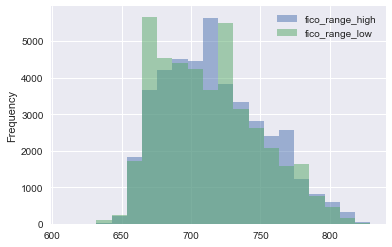

In [19]:
fico_columns = ['fico_range_high','fico_range_low']

print(loan.shape[0])
loan.dropna(subset=fico_columns,inplace=True)
print(loan.shape[0])

loan[fico_columns].plot.hist(alpha=0.5,bins=20);

In [20]:
loan['fico_average'] = (loan['fico_range_high'] + loan['fico_range_low']) / 2
drop_cols = ['fico_range_low','fico_range_high','last_fico_range_low',
             'last_fico_range_high']
loan = loan.drop(drop_cols, axis=1)
loan.shape

(42535, 23)

C:\Users\hp\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


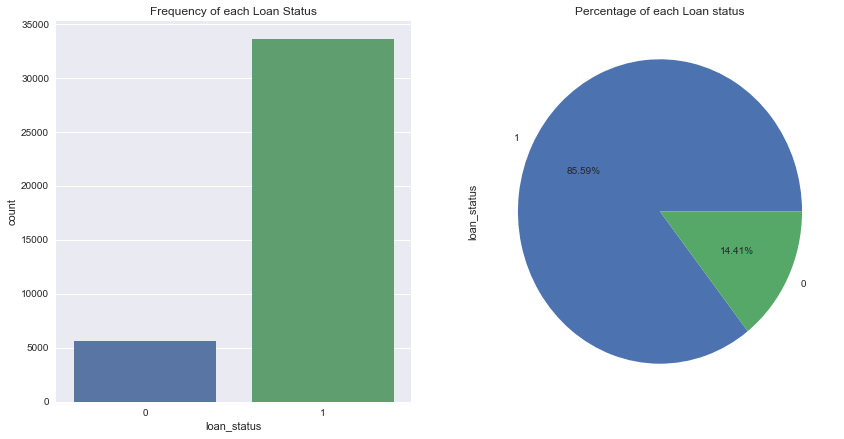

In [21]:
loan = loan[(loan["loan_status"] == "Fully Paid") |
                            (loan["loan_status"] == "Charged Off")]

mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
loan = loan.replace(mapping_dictionary)
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=loan,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
loan.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

# Preprocessing the data

In [22]:
loan["loan_status"].value_counts()


1    33586
0     5653
Name: loan_status, dtype: int64

In [23]:
loan = loan.drop("pub_rec_bankruptcies",axis=1)
loan = loan.dropna()
loan['revol_util'] = loan['revol_util'].str.rstrip('%').astype('float')
loan = loan.drop(['last_credit_pull_d','addr_state','title','earliest_cr_line'],axis=1)
nominal_columns = ["home_ownership", "verification_status", "purpose", "term"]
dummy_df = pd.get_dummies(loan[nominal_columns])
loan = pd.concat([loan, dummy_df], axis=1)
loan = loan.drop(nominal_columns, axis=1)
loan.head()

,loan_amnt,installment,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,162.87,10+ years,24000.0,1,27.65,0.0,1.0,3.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,2500.0,59.83,< 1 year,30000.0,0,1.00,0.0,5.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2400.0,84.33,10+ years,12252.0,1,8.72,0.0,2.0,2.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,10000.0,339.31,10+ years,49200.0,1,20.00,0.0,1.0,10.0,0.0,...,0,0,0,1,0,0,0,0,1,0
5,5000.0,156.46,3 years,36000.0,1,11.20,0.0,3.0,9.0,0.0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
mapping_dictionary = {"emp_length":{ "10+ years": 10, "< 1 year": 0, "1 year":1, "2 years":2, "3 years":3, "4 years":4,
                                   "5 years":5, "6 years":6, "7 years":7, "8 years":8, "9 years":9, "n/a":-1}}
loan = loan.replace(mapping_dictionary)
loan.to_csv("filtered_loans.csv",index=False)

In [25]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Split the data for training and testing

In [26]:
result = loan["loan_status"]
loan = loan.drop(['loan_status'],axis=1)
[loan_train,loan_test,result_train,result_test] = train_test_split(loan,result,test_size=0.3,random_state=69)
result_train = pd.get_dummies(result_train)

In [83]:
np.random.seed(1)
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten,Dropout
from keras.optimizers import Adam,SGD,RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Build the ANN

In [84]:
model=Sequential()
model.add(Dense(units=42 ,kernel_initializer= 'uniform', input_dim =37,activation='linear'))
model.add(Dense(units = 28, kernel_initializer = 'uniform',activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 20, kernel_initializer = 'uniform',activation='linear'))
model.add(Dropout(0.3))
model.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'softmax'))
adam = Adam(lr=0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 42)                1596      
_________________________________________________________________
dense_41 (Dense)             (None, 28)                1204      
_________________________________________________________________
dropout_20 (Dropout)         (None, 28)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 20)                580       
_________________________________________________________________
dropout_21 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 42        
Total params: 3,422
Trainable params: 3,422
Non-trainable params: 0
_________________________________________________________________


# Handle data imbalance by adjusting the weights

In [85]:
class_weight = {1 : 1.,
    0: 5.93962526,
                
    }

In [86]:
def g(x):
        max=0
        value=0;
        for j in range(0,2):
            if(x[j]>max):
                max=x[j]
                value=j
                
        return (value) 

# Fit the data and generate output for Test data

In [87]:
history=model.fit(loan_train,result_train,epochs=50,class_weight=class_weight,batch_size=600)
y_pred=model.predict(loan_test)
print("YPRED",y_pred)
realpred=[]
for i in range(0,len(y_pred)):
    p=g(y_pred[i])
    
    realpred.append(p)
    
print(classification_report(result_test,realpred))
print(np.mean(result_test!=realpred))



print(realpred)
print(result_test)

Epoch 1/50
26686/26686 [==============================] - 2s 71us/step - loss: 1.5461 - acc: 0.5526
Epoch 2/50
26686/26686 [==============================] - 1s 24us/step - loss: 1.1693 - acc: 0.7456
Epoch 3/50
26686/26686 [==============================] - 1s 29us/step - loss: 1.1693 - acc: 0.8033
Epoch 4/50
26686/26686 [==============================] - 1s 26us/step - loss: 1.1694 - acc: 0.7846
Epoch 5/50
26686/26686 [==============================] - 1s 41us/step - loss: 1.1658 - acc: 0.7844
Epoch 6/50
26686/26686 [==============================] - 1s 27us/step - loss: 1.1708 - acc: 0.8163
Epoch 7/50
26686/26686 [==============================] - 1s 27us/step - loss: 1.1656 - acc: 0.7720
Epoch 8/50
26686/26686 [==============================] - 1s 36us/step - loss: 1.1672 - acc: 0.7573
Epoch 9/50
26686/26686 [==============================] - 1s 34us/step - loss: 1.1653 - acc: 0.7567
Epoch 10/50
26686/26686 [==============================] - 1s 28us/step - loss: 1.1689 - acc: 0.7939

# Confusion matrix

In [88]:
from sklearn.metrics import confusion_matrix

confusion_matrix(result_test,realpred)

array([[ 857,  800],
       [3723, 6057]])

# Save the model

In [97]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('my_model_loan.h5')

# Deletes the existing model
del model  

# Returns a compiled model identical to the previous one
model = load_model('my_model_loan.h5')

# Predict for sample output(Single prediction)

In [95]:
x=np.vstack([[7200.0, 233.65, 5, 10000.0, 8.96, 0.0, 2.0, 6.0, 0.0, 3565.0,70.0, 18.0, 707.0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,0,0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]])



x.shape

(1, 37)

In [96]:
y=model.predict(x)
for i in range(0,len(y)):
    p=g(y[i])
print(p)               

0
